<a href="https://colab.research.google.com/github/IT21305900/DL-Lab8/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# 1. Define the GridWorld environment
class GridWorld:
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros((self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = (4, np.random.randint(0, 5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1, 3)
        self.gold_location = (0, 3)
        self.terminal_states = [self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[self.bomb_location] = -10
        self.grid[self.gold_location] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def get_available_actions(self):
        return self.actions

    def agent_on_map(self):
        """Returns the current location of the agent on the grid for visualization"""
        grid = np.zeros((self.height, self.width))
        grid[self.current_location] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for moving to a new location"""
        return self.grid[new_location]

    def make_step(self, action):
        """Moves the agent in the specified direction and returns the reward."""
        last_location = self.current_location

        if action == 'UP' and last_location[0] > 0:
            self.current_location = (self.current_location[0] - 1, self.current_location[1])
        elif action == 'DOWN' and last_location[0] < self.height - 1:
            self.current_location = (self.current_location[0] + 1, self.current_location[1])
        elif action == 'LEFT' and last_location[1] > 0:
            self.current_location = (self.current_location[0], self.current_location[1] - 1)
        elif action == 'RIGHT' and last_location[1] < self.width - 1:
            self.current_location = (self.current_location[0], self.current_location[1] + 1)

        reward = self.get_reward(self.current_location)
        return reward

    def check_state(self):
        """Checks if the agent is in a terminal state (gold or bomb)"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'
        return 'NON-TERMINAL'

In [ ]:
# 2. Define the DQN Agent using Keras
class DQN_Agent:
    def __init__(self, environment, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, alpha=0.001):
        self.environment = environment
        self.memory = deque(maxlen=2000)  # Replay buffer
        self.gamma = gamma                # Discount factor
        self.epsilon = epsilon            # Exploration rate
        self.epsilon_min = epsilon_min    # Minimum exploration rate
        self.epsilon_decay = epsilon_decay# Decay rate for epsilon
        self.alpha = alpha                # Learning rate

        self.state_size = environment.height * environment.width # State size is grid size (flattened)
        self.action_size = len(environment.actions)              # Number of possible actions

        # Initialize neural network model
        self.model = self._build_model()

    def _build_model(self):
        """Builds a neural network model for DQN"""
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.alpha))
        return model


    def remember(self, state, action, reward, next_state, done):
        """Store experiences in replay buffer"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Select action using epsilon-greedy policy"""
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.environment.actions)  # Random action (explore)
        else:
            q_values = self.model.predict(state.reshape(1, -1))
            return self.environment.actions[np.argmax(q_values[0])]  # Best action (exploit)

    def replay(self, batch_size):
        """Train the neural network using experience replay"""
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape(1, -1))[0])

            target_f = self.model.predict(state.reshape(1, -1))
            target_f[0][self.environment.actions.index(action)] = target

            # Train the neural network with the updated target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)

        # Decay epsilon to reduce exploration over time
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [ ]:
# 3. Define the play function for training
def play_dqn(environment, agent, trials=500, max_steps_per_episode=1000, batch_size=32):
    """Play function that runs the DQN agent and trains the model"""
    reward_per_episode = []  # Performance log

    for trial in range(trials):
        cumulative_reward = 0
        step = 0
        game_over = False
        state = np.reshape(environment.agent_on_map(), (environment.height * environment.width))

        while step < max_steps_per_episode and not game_over:
            action = agent.act(state)
            reward = environment.make_step(action)
            next_state = np.reshape(environment.agent_on_map(), (environment.height * environment.width))

            game_over = environment.check_state() == 'TERMINAL'
            agent.remember(state, action, reward, next_state, game_over)

            state = next_state
            cumulative_reward += reward
            step += 1

            if game_over:
                environment.__init__()

        agent.replay(batch_size)  # Train the agent
        reward_per_episode.append(cumulative_reward)

    return reward_per_episode

In [ ]:
# 4. Initialize the environment and agent
environment = GridWorld()
dqn_agent = DQN_Agent(environment)


In [ ]:
# 5. Train the DQN agent
reward_per_episode = play_dqn(environment, dqn_agent, trials=50)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

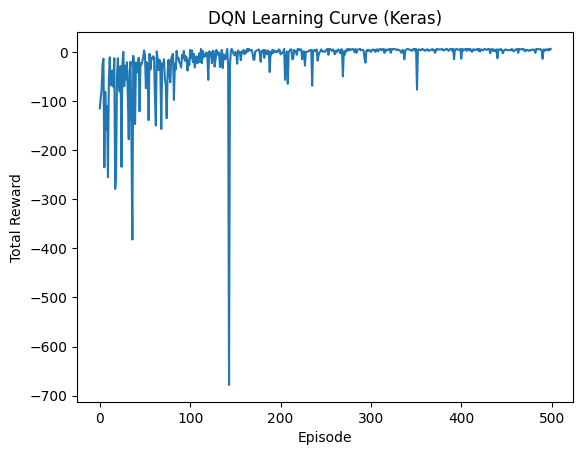

In [ ]:
# 6. Plot the learning curve
plt.plot(reward_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Learning Curve (Keras)')
plt.show()